# Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import os 
import shutil
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

# Analyzing the dataset

In [3]:
movies = pd.read_csv('.\Dataset\movies.csv',sep=';',encoding='latin-1').drop('Unnamed: 3',axis=1)
print('Shape of this dataset :',movies.shape)
movies.head()

Shape of this dataset : (3883, 3)


,movieId,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings = pd.read_csv('.\Dataset\\ratings.csv',sep=';')
print('Shape of this dataset :',ratings.shape)
ratings.head()

Shape of this dataset : (1000209, 4)


,userId,movieId,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [5]:
users = pd.read_csv('.\Dataset\\users.csv',sep=';')
print('Shape of this dataset :',users.shape)
users.head()

Shape of this dataset : (6040, 5)


,userId,gender,age,occupation,zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,2460
4,5,M,25,20,55455


Shape of this pivot table : (3706, 6040)


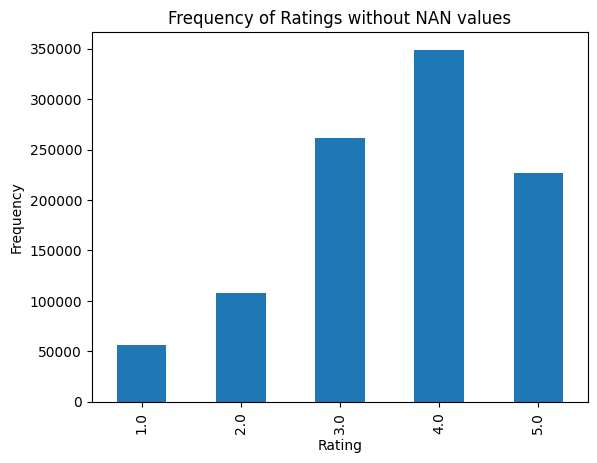

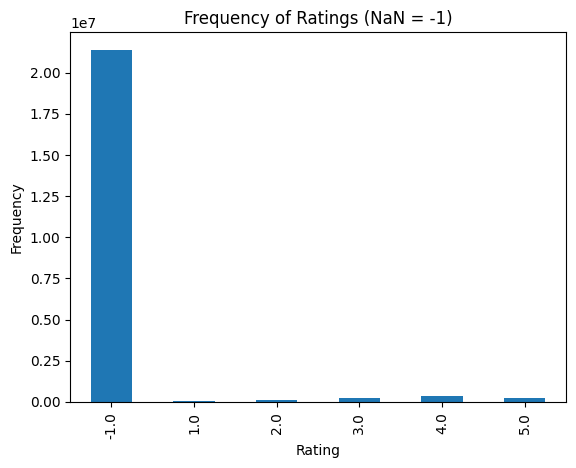

In [33]:
# Pivot table for ratings given by each user to each movie without filling NaN values
rating_pivot = ratings.pivot_table(values='rating',columns='userId',index='movieId')
print('Shape of this pivot table :',rating_pivot.shape)
# rating_pivot.head() 

# Count the number of occurrences of each rating
rating_counts = rating_pivot.stack().value_counts().sort_index()

# Create a bar graph of the rating counts
rating_counts.plot(kind='bar')

# Set the axis labels and title
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Frequency of Ratings without NAN values')
plt.show() 

# Fill the NaN values with -1 
rating_pivot = rating_pivot.fillna(-1)
rating_counts = rating_pivot.stack().value_counts().sort_index()
rating_counts.plot(kind='bar')
# Set the axis labels and title
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Frequency of Ratings (NaN = -1)')
plt.show() 

# Collaborative Filtering: getting 50 closest movies

In [34]:
# Pivot table for ratings given by each user to each movie
rating_pivot = ratings.pivot_table(values='rating',columns='userId',index='movieId')
print('Shape of this pivot table :',rating_pivot.shape)
rating_pivot.head()

Shape of this pivot table : (3706, 6040)


userId,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
movieId,,,,,,,,,,,,,,,,,,,,,
1,5.0,NaN,NaN,NaN,NaN,4.0,NaN,4.0,5.0,5.0,...,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,3.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,...,NaN,NaN,NaN,NaN,2.0,2.0,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN


In [15]:
# Applying KNN algorithm on the pivot table 
# nn_algo = NearestNeighbors(metric='cosine')
# nn_algo.fit(rating_pivot)

NearestNeighbors(metric='cosine')

In [10]:
class Recommender:
    def __init__(self, movies, ratings, users):
        # This list will stored movies that called atleast ones using recommend_on_movie method
        self.hist = [] 
        self.ishist = False # Check if history is empty 
        self.movies = movies
        self.ratings = ratings
        self.users = users 
        self.nn_algo = NearestNeighbors(metric='cosine')
        self.rating_pivot = self.ratings.pivot_table(values='rating',columns='userId',index='movieId').fillna(0)
    
    # This method will recommend movies based on a movie that passed as the parameter
    def recommend_on_movie(self,movie,n_reccomend = 10):
        self.ishist = True
        movieid = int(self.movies[self.movies['title']==movie]['movieId'])
        self.hist.append(movieid)
        distance,neighbors = self.nn_algo.kneighbors([self.rating_pivot.loc[movieid]],n_neighbors=n_reccomend+1)
        movieids = [self.rating_pivot.iloc[i].name for i in neighbors[0]]
        recommeds = [str(self.movies[self.movies['movieId']==mid]['title']).split('\n')[0].split('  ')[-1] for mid in movieids if mid not in [movieid]]
        return recommeds[:n_reccomend]
    
    # This method will recommend movies based on history stored in self.hist list
    def recommend_on_history(self,n_reccomend = 10):
        if self.ishist == False:
            return print('No history found')
        history = np.array([list(self.rating_pivot.loc[mid]) for mid in self.hist])
        distance,neighbors = self.nn_algo.kneighbors([np.average(history,axis=0)],n_neighbors=n_reccomend + len(self.hist))
        movieids = [self.rating_pivot.iloc[i].name for i in neighbors[0]]
        recommeds = [str(self.movies[self.movies['movieId']==mid]['title']).split('\n')[0].split('  ')[-1] for mid in movieids if mid not in self.hist]
        return recommeds[:n_reccomend] 
    
    def fit(self):
        
        self.nn_algo.fit(self.rating_pivot)
        return self.nn_algo

In [14]:
recommender = Recommender(movies,ratings,users) 
recommender.fit()

NearestNeighbors(metric='cosine')

In [15]:
# Recommendation based on past watched movies, but the object just initialized. So, therefore no history found
print("Movies: \n", recommender.recommend_on_history() )
print("History:\n" ,recommender.hist)

No history found
Movies: 
 None
History:
 []


In [16]:
# Recommendation based on this movie 
print("Movies: \n", recommender.recommend_on_movie('Father of the Bride Part II (1995)') )
print("History: \n",recommender.hist)

Movies: 
 ['Home Alone (1990)', 'Home Alone 2', 'Mighty Ducks, The (1992)', 'Mrs. Doubtfire (1993)', 'Liar Liar (1997)', 'First Wives Club, The (1996)', "You've Got Mail (1998)", 'Flintstones, The (1994)', 'Multiplicity (1996)', 'Nine Months (1995)']
History: 
 [5]


In [17]:
print(recommender.recommend_on_history())

['Home Alone (1990)', 'Home Alone 2', 'Mighty Ducks, The (1992)', 'Mrs. Doubtfire (1993)', 'Liar Liar (1997)', 'First Wives Club, The (1996)', "You've Got Mail (1998)", 'Flintstones, The (1994)', 'Multiplicity (1996)', 'Nine Months (1995)']


# Content Based Filtering on the movies we got from above

In [36]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(stop_words='english')
genres = vectorizer.fit_transform(movies.genres).toarray()
feature_names = vectorizer.get_feature_names_out()
contents = pd.DataFrame(genres,columns= feature_names)
print('Shape of the content table :',contents.shape)
contents.head()

Shape of the content table : (3883, 347)


,1919,1956,1963,1968,1974,1977,1978,1979,1980,1981,...,wight,willowbrook,witch,worrying,wrath,years,yellow,yes,york,yu
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
print(feature_names)

['1919' '1956' '1963' '1968' '1974' '1977' '1978' '1979' '1980' '1981'
 '1982' '1983' '1984' '1985' '1986' '1987' '1988' '1989' '1990' '1991'
 '1992' '1993' '1994' '1995' '1996' '1997' '1998' '1999' '2000' '3d' '79'
 'aardman' 'action' 'adventure' 'adventures' 'airport' 'al' 'alive'
 'america' 'american' 'angels' 'animation' 'annihilation' 'arc'
 'assassination' 'assignment' 'baloo' 'bananas' 'batch' 'bath' 'bear'
 'beginning' 'best' 'bigger' 'blood' 'bloodline' 'blue' 'body' 'bomb'
 'bordello' 'bowles' 'brain' 'burn' 'business' 'calls' 'candy' 'carrie'
 'castrato' 'chainsaw' 'chao' 'chapter' 'child' 'children' 'cinderella'
 'citizens' 'city' 'clear' 'comedy' 'conflict' 'contact' 'control'
 'country' 'crackdown' 'crime' 'cruise' 'curly' 'curse' 'cut' 'cyberspace'
 'dare' 'dark' 'day' 'dead' 'death' 'deliver' 'demon' 'der' 'detective'
 'documentary' 'dog' 'dollhouse' 'dorothy' 'drama' 'dream' 'ducks' 'eagle'
 'earth' 'empire' 'end' 'endgame' 'episode' 'evil' 'face' 'fall' 'fantasy'
 'fa

In [38]:
nn_algo = NearestNeighbors(metric='cosine')
nn_algo.fit(contents)

NearestNeighbors(metric='cosine')

In [18]:
from sklearn.feature_extraction.text import CountVectorizer

class Recommender:
    def __init__(self, movies, ratings, users):
        # This list will stored movies that called atleast ones using recommend_on_movie method
        self.hist = [] 
        self.ishist = False # Check if history is empty 
        self.movies = movies
        self.ratings = ratings
        self.users = users
        self.nn_algo = NearestNeighbors(metric='cosine')

        vectorizer = CountVectorizer(stop_words='english')
        genres = vectorizer.fit_transform(self.movies.genres).toarray()
        feature_names = vectorizer.get_feature_names_out() 
        self.contents = pd.DataFrame(genres,columns= feature_names)
    
    # This method will recommend movies based on a movie that passed as the parameter
    def recommend_on_movie(self,movie,n_reccomend = 10):
        self.ishist = True
        iloc = self.movies[self.movies['title']==movie].index[0]
        self.hist.append(iloc)
        distance,neighbors = self.nn_algo.kneighbors([self.contents.iloc[iloc]],n_neighbors=n_reccomend+1)
        recommeds = [self.movies.iloc[i]['title'] for i in neighbors[0] if i not in [iloc]]
        return recommeds[:n_reccomend]
    
    # This method will recommend movies based on history stored in self.hist list
    def recommend_on_history(self,n_reccomend = 10):
        if self.ishist == False:
            return print('No history found')
        history = np.array([list(self.contents.iloc[iloc]) for iloc in self.hist])
        distance,neighbors = self.nn_algo.kneighbors([np.average(history,axis=0)],n_neighbors=n_reccomend + len(self.hist))
        recommeds = [self.movies.iloc[i]['title'] for i in neighbors[0] if i not in self.hist]
        return recommeds[:n_reccomend] 
    
    def fit(self):
        self.nn_algo.fit(self.contents)
        return self.nn_algo

In [19]:
recommender = Recommender(movies, ratings, users) 
recommender.fit()

NearestNeighbors(metric='cosine')

In [20]:
# Recommendation based on past watched movies, but the object just initialized. So, therefore no history found
print("Movies: \n", recommender.recommend_on_history() )
print("History:\n" ,recommender.hist)

No history found
Movies: 
 None
History:
 []


In [21]:
# Recommendation based on this movie 
print("Movies: \n", recommender.recommend_on_movie('Father of the Bride Part II (1995)') )
print("History: \n",recommender.hist)

Movies: 
 ['Life with Mikey (1993)', 'Made in America (1993)', 'SubUrbia (1997)', 'Jimmy Hollywood (1994)', '8 1/2 Women (1999)', 'Waiting for Guffman (1996)', 'Kolya (1996)', 'Twelve Chairs, The (1970)', 'Pest, The (1997)', 'Guantanamera (1994)']
History: 
 [4]


c:\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


In [22]:
print(recommender.recommend_on_history())

['Life with Mikey (1993)', 'Made in America (1993)', 'SubUrbia (1997)', 'Jimmy Hollywood (1994)', '8 1/2 Women (1999)', 'Waiting for Guffman (1996)', 'Kolya (1996)', 'Twelve Chairs, The (1970)', 'Pest, The (1997)', 'Guantanamera (1994)']


c:\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


# Evaluation

In [23]:
from sklearn.metrics import average_precision_score

def evaluate(recommender, test_set, k=10):
    ap_scores = []
    for user, actual_items in test_set.items():
        recommended_items = recommender.recommend_on_history(n_reccomend=k)
        ap_scores.append(average_precision_score(actual_items, recommended_items))
    return sum(ap_scores) / len(ap_scores)

In [24]:
from sklearn.model_selection import train_test_split 
from collections import defaultdict
from sklearn.metrics import average_precision_at_k, mean_average_precision_at_k

# split data into train and test sets
train_data, test_data = train_test_split(ratings, test_size=0.2, random_state=42)

# create test set dictionary
test_set = defaultdict(list)
for _, row in test_data.iterrows():
    test_set[row['userId']].append(row['movieId'])  

# initialize recommender object
recommender = Recommender()

# train recommender on train data
recommender.fit(train_data)

# evaluate recommender on test set
mapk = evaluate(recommender, test_set, k=10)
print(f'MAP@10: {mapk:.4f}')



ImportError: cannot import name 'average_precision_at_k' from 'sklearn.metrics' (c:\Python311\Lib\site-packages\sklearn\metrics\__init__.py)

In [36]:
users[users['userId']==5]

,userId,gender,age,occupation,zip-code
4,5,M,25,20,55455


In [37]:
ratings[ratings['userId']==5]

,userId,movieId,rating,timestamp
254,5,2987,4,978243170
255,5,2333,4,978242607
256,5,1175,5,978244759
257,5,39,3,978245037
258,5,288,2,978246585
...,...,...,...,...
447,5,34,4,978244603
448,5,356,1,978241112
449,5,357,2,978245829
450,5,36,3,978244808
